In [1]:
#REFERENCES:
#https://medium.com/@tifa2up/image-classification-using-deep-neural-networks-a-beginner-friendly-approach-using-tensorflow-94b0a090ccd4
#https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

In [1]:
import numpy as np
import pandas as pd
import csv
import cv2
import glob
import shutil
import os
import subprocess
import random
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data_path = '/Users/dnyanadajoshi/OneDrive/Ono Project/data/0624/'

#Conceptually global for this notebook
detect = data_path+"detection_data/"
positive_path = detect+"positive/"
negative_path = detect+"negative/"
results = "../results/"
ext = ".bmp"

In [3]:
#TODO: check pros and cons for os, subprocess, shutil - MAKE A NOTE SOMEWHERE
def remove_nonsquares(negative):
    
    files = glob.glob(negative+"*"+ext)
    for f in files:
        img = cv2.imread(f,0)
        if img.shape != (60,60):
            os.remove(f)
            
def create_dataset(path):
    
    files = glob.glob(data_path+"??_cropped/??_?/names_*.csv")
    subprocess.run(["mkdir", detect[:-1]])
    subprocess.run(["mkdir", positive_path[:-1]])
    subprocess.run(["mkdir", negative_path[:-1]])
    output_file = open(detect+"detection_labels.csv","w")
    writer = csv.writer(output_file)
    for fi in files:
        with open(fi,"r") as f:
            reader = csv.reader(f)
            for row in reader:
                (name, label) = tuple(row)
                label_path = negative_path
                if label == '1':
                    label_path = positive_path
                shutil.copyfile(data_path+name, label_path+name.split("/")[-1])
    remove_nonsquares(negative_path)
    files = glob.glob(positive_path+"*"+ext)
    for f in files:
        writer.writerow([f, '1'])
    files = glob.glob(negative_path+"*"+ext)
    for f in files:
        writer.writerow([f, '0'])
    output_file.close()
create_dataset(data_path)

In [4]:
def load_dataset(path, split=0.8):
    X = []
    Y = []
    data = []
    with open(path,"r") as f:
        reader = csv.reader(f)
        for row in reader:
            (name, label) = tuple(row)
            data.append((cv2.imread(name), int(label)))
        random.shuffle(data)
        X = [d[0] for d in data]
        Y = [d[1] for d in data]
        Y = to_categorical(Y)
        Xtrain = X[:int(0.6*len(X))]
        Xval = X[int(0.6*len(X)):int(0.8*len(X))]
        Xtest = X[int(0.8*len(X)):]
        Ytrain = Y[:int(0.6*len(Y))]
        Yval = Y[int(0.6*len(Y)):int(0.8*len(Y))]
        Ytest = Y[int(0.8*len(Y)):]
    return (np.asarray(Xtrain), Ytrain, np.asarray(Xval), Yval, np.asarray(Xtest), Ytest)
(Xtrain, Ytrain, Xval, Yval, Xtest,Ytest) = load_dataset(detect+"detection_labels.csv")
Xtrain = np.concatenate((Xtrain, Xval))
Ytrain = np.concatenate((Ytrain, Yval))
print(Xtrain.shape, Ytrain.shape)

(2606, 60, 60, 3) (2606, 2)


In [5]:
def prep_data(X):
    #0 mean centering and normalization? Need?
    pass

In [6]:
def Model(learn_rate = 0.01, n_layers=1, n_feature_maps=32,  mm = 0.9, ):
    model = Sequential()
    for i in range(n_layers):
        model.add(Conv2D(n_feature_maps, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(60, 60, 3)))
        model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = SGD(lr=learn_rate, momentum=mm)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = Model()
plot_model(model, to_file=results+'model.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
#Use sklearn train test split, also use test data separately
def train(model, train, val, n_epochs=20):
    trainx, trainy = train[0], train[1]
    valx, valy = val[0], val[1]
    return model.fit(trainx, trainy, validation_data=(valx, valy), epochs=n_epochs)
history = train(model, (Xtrain, Ytrain), (Xval, Yval))

Instructions for updating:
Use tf.cast instead.
Train on 1954 samples, validate on 652 samples
Epoch 1/20
1954/1954 [==============================] - 11s 6ms/step - loss: 0.4420 - acc: 0.8327 - val_loss: 0.3039 - val_acc: 0.8896
Epoch 2/20
1954/1954 [==============================] - 11s 6ms/step - loss: 0.2605 - acc: 0.8936 - val_loss: 0.2821 - val_acc: 0.8926
Epoch 3/20
1954/1954 [==============================] - 9s 5ms/step - loss: 0.1394 - acc: 0.9452 - val_loss: 0.3685 - val_acc: 0.8650
Epoch 4/20
1954/1954 [==============================] - 9s 5ms/step - loss: 0.1419 - acc: 0.9509 - val_loss: 0.3353 - val_acc: 0.8911
Epoch 5/20
1954/1954 [==============================] - 9s 5ms/step - loss: 0.0847 - acc: 0.9703 - val_loss: 0.3582 - val_acc: 0.9064
Epoch 6/20
1954/1954 [==============================] - 9s 5ms/step - loss: 0.0522 - acc: 0.9826 - val_loss: 1.2615 - val_acc: 0.7209
Epoch 7/20
1954/1954 [==============================] - 9s 5ms/step - loss: 0.0375 - acc: 0.9867 - 

In [ ]:
#Grid search 
model = KerasClassifier(build_fn=Model, epochs = 10, batch_size = 16)
lr = [0.01, 0.005]
layers = [2,3]
features = [32]
param_grid = dict(learn_rate=lr, n_layers = layers, n_feature_maps=features)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(Xtrain, Ytrain)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
print("total time:",time()-start)

/Users/dnyanadajoshi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/10


In [9]:
def evaluate(Xtest, Ytest, metrics):
    scores = model.evaluate(Xtest, Ytest,verbose=0)
    for m in range(len(metrics)):
        print(metrics[m],": ",scores[m])
evaluate(Xtest, Ytest, model.metrics_names)

loss :  4.076985095907574
acc :  0.6288343561938935


In [15]:
print(history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
f = open("results.csv","w")
writer = csv.writer(f)
for i in range(len(val_acc)):
    writer.writerow([acc[i], loss[i], val_acc[i], val_loss[i]])

{'val_loss': [0.3038974774578598, 0.2821037877648155, 0.36854379893811934, 0.3353429155115701, 0.3581763938800689, 1.2614925361118434, 0.35411182183063833, 0.45270876421884526, 0.3860164413834276, 0.34432427779388575, 0.4512522805230749, 0.48503617658936904, 0.46628384536097933, 0.5565022290484306, 0.5589508600761554, 0.47812816829769156, 0.4946437609707651, 0.5140138356232204, 0.5261993367979132, 4.133640805636447], 'val_acc': [0.8895705521472392, 0.8926380368098159, 0.8650306752122985, 0.8911042944785276, 0.9064417181570837, 0.7208588960711941, 0.9110429451509487, 0.9171779144761021, 0.9279141104294478, 0.9279141104294478, 0.9217791414699672, 0.88650306711899, 0.9141104294478528, 0.9110429451509487, 0.8834355824564132, 0.8512269942307034, 0.8650306752122985, 0.900306748100585, 0.8742331292000285, 0.6380368098159509], 'loss': [0.4419620857024022, 0.26054692092974086, 0.13941938288990283, 0.14185502423600752, 0.08470722040769156, 0.05216546414826092, 0.037450992203905735, 0.04465172175

In [10]:
df = pd.read_csv("results.csv",header=None, names=["acc", "loss", "val_acc","val_loss"])
val_loss = list(df["val_loss"])
loss = list(df["loss"])
val_loss = list(df["val_loss"])
loss = list(df["loss"])

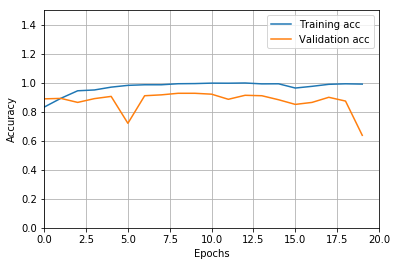

In [14]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(df["acc"])
plt.plot(df["val_acc"])
plt.ylim(0, 1.5)
plt.xlim(0,20)
plt.grid()
plt.legend(['Training acc','Validation acc'],loc="upper right")
plt.show()